In [2]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

In [3]:
imdb = pd.read_csv('imdb_labelled.txt', delimiter= '\t', header=None)
imdb.head()

,0,1
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [4]:
imdb.columns = ['review', 'pos_neg']

In [5]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
review     748 non-null object
pos_neg    748 non-null int64
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


### Iteration #1

For the first iteration of our model, I will compile a list of generally positive words that should help our model to properly classify between positive and negative movie reviews.  

In [6]:
keywords = ['best', 'love', 'good', 'great', 'beautiful', 'enjoy', 'perfect', 'wonderful', 'nice', 'cool']

for key in keywords:
    imdb[str(key)] = imdb.review.str.contains(' '+str(key)+ ' ', case=False)

           pos_neg  best  love  good  great  beautiful  enjoy  perfect  \
pos_neg       1.00  0.05  0.06  0.08   0.11       0.01   0.01     0.08   
best          0.05  1.00  0.04  0.09   0.12       0.21   0.21    -0.01   
love          0.06  0.04  1.00  0.14   0.12       0.11   0.22    -0.01   
good          0.08  0.09  0.14  1.00   0.11       0.13   0.13    -0.02   
great         0.11  0.12  0.12  0.11   1.00       0.16   0.24    -0.02   
beautiful     0.01  0.21  0.11  0.13   0.16       1.00   0.40    -0.01   
enjoy         0.01  0.21  0.22  0.13   0.24       0.40   1.00    -0.01   
perfect       0.08 -0.01 -0.01 -0.02  -0.02      -0.01  -0.01     1.00   
wonderful     0.12  0.11 -0.02  0.01   0.07       0.10   0.10    -0.01   
nice          0.08 -0.01 -0.01 -0.02  -0.02      -0.01  -0.01    -0.01   
cool          0.05 -0.01  0.11  0.13   0.07      -0.01  -0.01    -0.01   

           wonderful  nice  cool  
pos_neg         0.12  0.08  0.05  
best            0.11 -0.01 -0.01  
love  

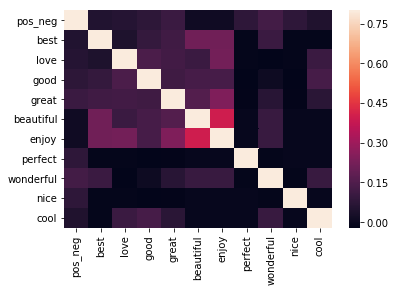

In [7]:
corrmat = imdb.corr()

print(corrmat)

sns.heatmap(corrmat, vmax=.8)
plt.show()

We note higher than normal correlation between 'beautiful' feature and 'enjoy' feature, though still fairly low at 0.396.

In [8]:
# Assign our feature data and target variable
data = imdb[keywords]
target = imdb['pos_neg']

In [9]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

print("Accuracy of model: {}".format((target == y_pred).sum()/data.shape[0]*100))

Number of mislabeled points out of a total 748 points : 316
Accuracy of model: 57.75401069518716


In [10]:
from sklearn.metrics import confusion_matrix
conmat = confusion_matrix(target, y_pred)
print(conmat)

[[341  21]
 [295  91]]


In [11]:
def sensitivity(confusion_matrix):
    return confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[1,0]) * 100

def specificity(confusion_matrix):
    return confusion_matrix[0,0] / (confusion_matrix[0,1] + confusion_matrix[0,0]) * 100

print('Sensitivity: ', sensitivity(conmat))
print('Specificity: ', specificity(conmat))

Sensitivity:  23.57512953367876
Specificity:  94.1988950276243


From this we see that the majority of the error is coming from failure to predict the positive reviews, with 92/386 of our errors failing to identify positive reviews. While our ability to identify negative reviews is at 341/362. So, we want to get better at predicting the positive reviews. 

In [12]:
# Test your model with different holdout groups.

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=20)
print('With 30% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 30% Holdout: 0.5644444444444444
Testing on Sample: 0.5775401069518716


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

array([0.52631579, 0.52631579, 0.61333333, 0.54666667, 0.6       ,
       0.56      , 0.67567568, 0.58108108, 0.59459459, 0.5       ])

After receiving roughly equal performance between the whole sample and the 20% holdout, I'll attempt to add a few features to improve the performance of the model. We also note that we have a sensitivity of 23.83% and a specificity of 94.2%, and fairly consistent scores upon cross validation though we do note potential overfitting on a couple of our folds.

### Iteration #2

The strategy for this iteration will be to take a look at the existing positive reviews and pull out potential high value words/features from them. 

In [14]:
print(imdb[imdb['pos_neg'] == 1]['review'])

4      The best scene in the movie was when Gerardo i...
7      Saw the movie today and thought it was a good ...
9      Loved the casting of Jimmy Buffet as the scien...
10                  And those baby owls were adorable.  
11     The movie showed a lot of Florida at it's best...
12     The Songs Were The Best And The Muppets Were S...
13                                     It Was So Cool.  
14     This is a very "right on case" movie that deli...
16     This review is long overdue, since I consider ...
17     I'll put this gem up against any movie in term...
18     It's practically perfect in all of them  a tr...
20     This if the first movie I've given a 10 to in ...
21     If there was ever a movie that needed word-of-...
22     Overall, the film is interesting and thought-p...
23     Plus, it was well-paced and suited its relativ...
24                               Give this one a look.  
25                                      I gave it a 10  
26     The Wind and the Lion is

In [15]:
keywords2 = ['best', 'loved', 'good', 'great', 'beautiful', 'love', 'lovely', 'enjoyed', 'perfect', 'wonderful', 'nice', 'cool', 'treat', 'worth', 'classic', '10', 'terrific', 'superb', 'well', 'interesting', 'entertaining']

for key in keywords2:
    imdb[str(key)] = imdb.review.str.contains(' '+str(key)+ ' ', case=False)

              pos_neg  best  love  good  great  beautiful  enjoy  perfect  \
pos_neg          1.00  0.05  0.06  0.08   0.11       0.01   0.01     0.08   
best             0.05  1.00  0.04  0.09   0.12       0.21   0.21    -0.01   
love             0.06  0.04  1.00  0.14   0.12       0.11   0.22    -0.01   
good             0.08  0.09  0.14  1.00   0.11       0.13   0.13    -0.02   
great            0.11  0.12  0.12  0.11   1.00       0.16   0.24    -0.02   
beautiful        0.01  0.21  0.11  0.13   0.16       1.00   0.40    -0.01   
enjoy            0.01  0.21  0.22  0.13   0.24       0.40   1.00    -0.01   
perfect          0.08 -0.01 -0.01 -0.02  -0.02      -0.01  -0.01     1.00   
wonderful        0.12  0.11 -0.02  0.01   0.07       0.10   0.10    -0.01   
nice             0.08 -0.01 -0.01 -0.02  -0.02      -0.01  -0.01    -0.01   
cool             0.05 -0.01  0.11  0.13   0.07      -0.01  -0.01    -0.01   
loved            0.07  0.07  0.08  0.04   0.12       0.15   0.15    -0.01   

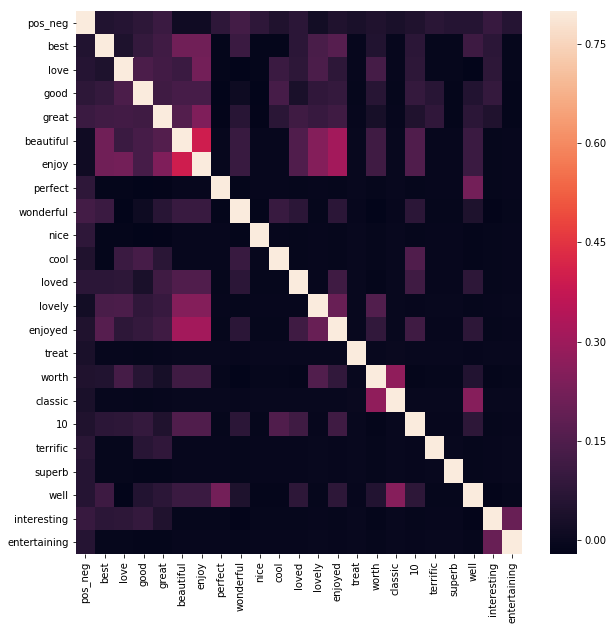

In [16]:
# Checking correlation amongst our features
corrmat2 = imdb.corr()

print(corrmat2)

plt.figure(figsize=(10, 10))
sns.heatmap(corrmat2, vmax=.8)
plt.show()

In [17]:
# Assigning our features and target variable
data2 = imdb[keywords2]
target = imdb['pos_neg']

In [18]:
# Display our results.
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data2, target)

# Classify, storing the result in a new variable.
y_pred2 = bnb.predict(data2)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data2.shape[0],
    (target != y_pred2).sum()
))

print("Accuracy of model: {}".format((target == y_pred2).sum()/data2.shape[0]*100))

Number of mislabeled points out of a total 748 points : 280
Accuracy of model: 62.56684491978609


In [19]:
# Get Confusion Matrix
conmat2 = confusion_matrix(target, y_pred2)
print(conmat2)

[[335  27]
 [253 133]]


In [20]:
# Print our Sensitivity/Specificity scores
print('Sensitivity: ', sensitivity(conmat2))
print('Specificity: ', specificity(conmat2))

Sensitivity:  34.4559585492228
Specificity:  92.5414364640884


In [21]:
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data2, target, test_size=0.3, random_state=20)
print('With 30% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data2, target).score(data2, target)))

With 30% Holdout: 0.6133333333333333
Testing on Sample: 0.6256684491978609


In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data2, target, cv=10)

array([0.63157895, 0.60526316, 0.65333333, 0.6       , 0.68      ,
       0.58666667, 0.7027027 , 0.59459459, 0.59459459, 0.58108108])

We do see better performance with the addition of more features so we will keep these additional features, with an accuracy jump from 57.8% to 62.6% as well as improving the sensitivity of our model from 23.6% to 34.5% which was our goal. 

#### Iteration #3

For this iteration, let's again add some features but instead of creating single word features, I'll try to add some phrases that again might improve our models ability to predict positive reviews.

In [23]:
imdb.iloc[:,0]

0      A very, very, very slow-moving, aimless movie ...
1      Not sure who was more lost - the flat characte...
2      Attempting artiness with black & white and cle...
3           Very little music or anything to speak of.  
4      The best scene in the movie was when Gerardo i...
5      The rest of the movie lacks art, charm, meanin...
6                                    Wasted two hours.  
7      Saw the movie today and thought it was a good ...
8                                   A bit predictable.  
9      Loved the casting of Jimmy Buffet as the scien...
10                  And those baby owls were adorable.  
11     The movie showed a lot of Florida at it's best...
12     The Songs Were The Best And The Muppets Were S...
13                                     It Was So Cool.  
14     This is a very "right on case" movie that deli...
15     It had some average acting from the main perso...
16     This review is long overdue, since I consider ...
17     I'll put this gem up aga

In [24]:
# Updating our keywords
keywords3 = ['best', 'loved', 'good', 'great', 'beautiful', 'love', 'lovely', 'enjoyed', 'perfect', 'wonderful', 'nice', 'cool', 'treat', 'worth', 'classic', '10', 'terrific', 'superb', 'well', 'interesting', 'entertaining', 'turned out to be', 'enough can not be said', 'stellar performance', 'if you have not seen this movie', 'makes up for', 'well-balanced']

# Adding the features to the dataframe
for key in keywords3:
    imdb[str(key)] = imdb.review.str.contains(' '+str(key)+ ' ', case=False)
    

                                 pos_neg  best  love  good  great  beautiful  \
pos_neg                             1.00  0.05  0.06  0.08   0.11       0.01   
best                                0.05  1.00  0.04  0.09   0.12       0.21   
love                                0.06  0.04  1.00  0.14   0.12       0.11   
good                                0.08  0.09  0.14  1.00   0.11       0.13   
great                               0.11  0.12  0.12  0.11   1.00       0.16   
beautiful                           0.01  0.21  0.11  0.13   0.16       1.00   
enjoy                               0.01  0.21  0.22  0.13   0.24       0.40   
perfect                             0.08 -0.01 -0.01 -0.02  -0.02      -0.01   
wonderful                           0.12  0.11 -0.02  0.01   0.07       0.10   
nice                                0.08 -0.01 -0.01 -0.02  -0.02      -0.01   
cool                                0.05 -0.01  0.11  0.13   0.07      -0.01   
loved                               0.07

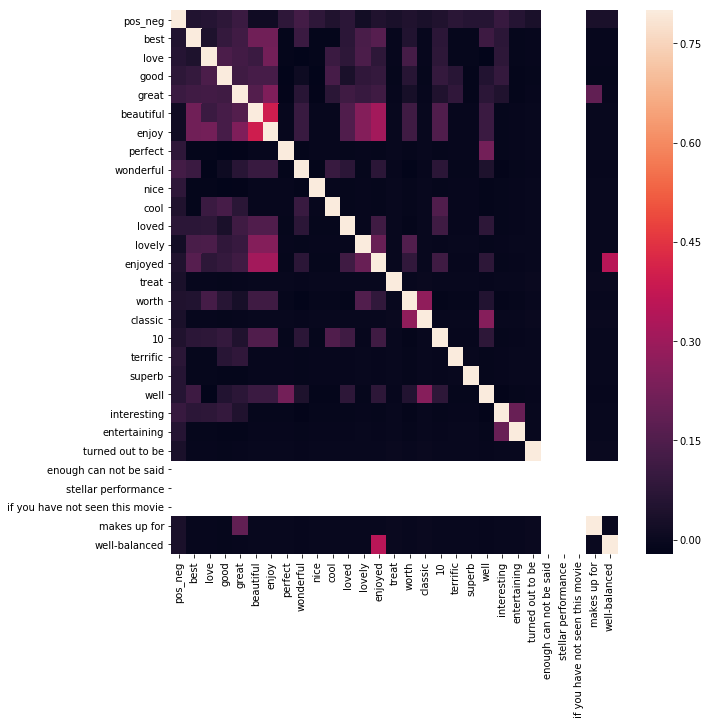

In [25]:
# Checking correlation amongst our features
corrmat3 = imdb.corr()

print(corrmat3)

plt.figure(figsize=(10, 10))
sns.heatmap(corrmat3, vmax=.8)
plt.show()

It looks like a few of our newer features aren't helpful so we will drop them and keep the better performing ones.

In [26]:
# Dropping poor features
imdb = imdb.drop(labels=['enough can not be said', 'stellar performance', 'if you have not seen this movie'], axis=1)

In [27]:
# Assigning our features and target variable
data3 = imdb.drop(['review', 'pos_neg'], axis=1)
target = imdb['pos_neg']

# Fit our model to the data.
bnb.fit(data3, target)

# Classify, storing the result in a new variable.
y_pred3 = bnb.predict(data3)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data3.shape[0],
    (target != y_pred3).sum()
))

print("Accuracy of model: {}".format((target == y_pred3).sum()/data3.shape[0]*100))

Number of mislabeled points out of a total 748 points : 279
Accuracy of model: 62.700534759358284


In [28]:
# Get Confusion Matrix
conmat3 = confusion_matrix(target, y_pred3)
print(conmat3)

# Print our Sensitivity/Specificity scores
print('Sensitivity: ', sensitivity(conmat3))
print('Specificity: ', specificity(conmat3))

[[335  27]
 [252 134]]
Sensitivity:  34.715025906735754
Specificity:  92.5414364640884


In [29]:
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data3, target, test_size=0.3, random_state=20)
print('With 30% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data3, target).score(data3, target)))

With 30% Holdout: 0.6177777777777778
Testing on Sample: 0.6270053475935828


In [30]:
# Perform Cross Validation with 10 k-folds
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data3, target, cv=10)

array([0.63157895, 0.60526316, 0.65333333, 0.6       , 0.68      ,
       0.58666667, 0.7027027 , 0.59459459, 0.59459459, 0.58108108])

Again we se slight improvement in our model performance though not as much compared to Iteration #1 to Iteration #2. We also see very slight improvement in our sensitivity without much loss in specificity. Through cross validation we see a bit much variation across our folds indicating some overfitting with some of our features. Let's try and address this in the next iteration.

#### Iteration #4

To address some of the overfitting in our model, I'll attempt to drop features that have lower correlation to our target variable as well as simplifying our feature-space. 

In [40]:
# Get top performing features in our correlation matrix

target = 'pos_neg'
nr_cols = 16
corrmat = imdb.corr()
print (corrmat.nlargest(nr_cols, target)[target])

pos_neg        1.00
wonderful      0.12
great          0.11
interesting    0.10
nice           0.08
perfect        0.08
good           0.08
loved          0.07
terrific       0.07
well           0.06
love           0.06
entertaining   0.06
superb         0.06
best           0.05
enjoyed        0.05
10             0.05
Name: pos_neg, dtype: float64


In [43]:
keywords4 = ['wonderful', 'great', 'interesting', 'nice', 'perfect', 'well', 'love', 'entertaining', 'superb', 'best', 'enjoyed', '10']

# Create new dataframe to hold simplified feature set.
new_imdb = pd.DataFrame()

# Adding the features to the dataframe
for key in keywords4:
    new_imdb[str(key)] = imdb.review.str.contains(' '+str(key)+ ' ', case=False)
    
# Add back in reviews and pos_neg columns
new_imdb['review'] = imdb['review']
new_imdb['pos_neg'] = imdb['pos_neg']

              wonderful  great  interesting  nice  perfect  well  love  \
wonderful          1.00   0.07        -0.02 -0.01    -0.01  0.04 -0.02   
great              0.07   1.00         0.05 -0.02    -0.02  0.07  0.12   
interesting       -0.02   0.05         1.00 -0.01    -0.01 -0.01  0.08   
nice              -0.01  -0.02        -0.01  1.00    -0.01 -0.01 -0.01   
perfect           -0.01  -0.02        -0.01 -0.01     1.00  0.22 -0.01   
well               0.04   0.07        -0.01 -0.01     0.22  1.00 -0.02   
love              -0.02   0.12         0.08 -0.01    -0.01 -0.02  1.00   
entertaining      -0.01  -0.01         0.20 -0.01    -0.01 -0.01 -0.01   
superb            -0.01  -0.01        -0.01 -0.01    -0.01 -0.01 -0.01   
best               0.11   0.12         0.07 -0.01    -0.01  0.11  0.04   
enjoyed            0.07   0.12        -0.01 -0.01    -0.01  0.08  0.08   
10                 0.07   0.05        -0.01 -0.01    -0.01  0.08  0.08   
pos_neg            0.12   0.11        

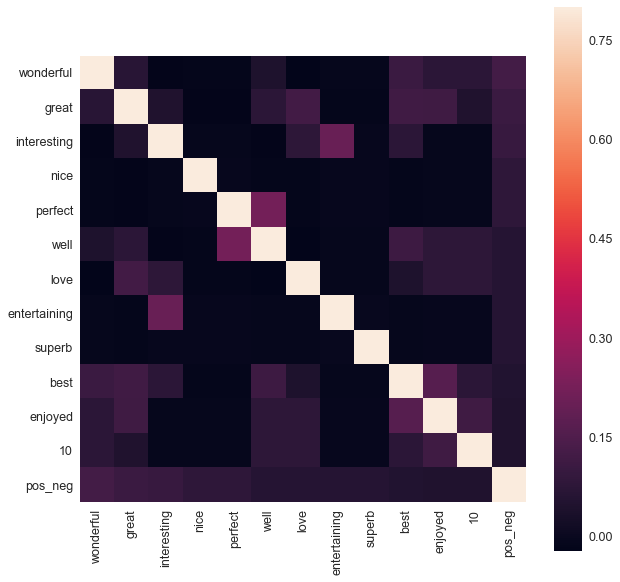

In [45]:
# Checking correlation amongst our features
corrmat4 = new_imdb.corr()

print(corrmat4)

plt.figure(figsize=(10, 10))
sns.heatmap(corrmat4, vmax=.8, square=True)
plt.show()

In [46]:
# Assigning our features and target variable
data4 = new_imdb.drop(['review', 'pos_neg'], axis=1)
target = new_imdb['pos_neg']

# Fit our model to the data.
bnb.fit(data4, target)

# Classify, storing the result in a new variable.
y_pred4 = bnb.predict(data4)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data4.shape[0],
    (target != y_pred4).sum()
))

print("Accuracy of model: {}".format((target == y_pred4).sum()/data4.shape[0]*100))

Number of mislabeled points out of a total 748 points : 307
Accuracy of model: 58.9572192513369


In [48]:
# Get Confusion Matrix
conmat4 = confusion_matrix(target, y_pred4)
print(conmat4)

# Print our Sensitivity/Specificity scores
print('Sensitivity: ', sensitivity(conmat4))
print('Specificity: ', specificity(conmat4))

[[347  15]
 [292  94]]
Sensitivity:  24.352331606217618
Specificity:  95.85635359116023


In [49]:
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data4, target, test_size=0.3, random_state=20)
print('With 30% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data4, target).score(data4, target)))

With 30% Holdout: 0.5911111111111111
Testing on Sample: 0.589572192513369


In [64]:
# Perform Cross Validation with 10 k-folds
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data4, target, cv=10)

array([0.56578947, 0.60526316, 0.54666667, 0.57333333, 0.65333333,
       0.58666667, 0.62162162, 0.55405405, 0.59459459, 0.59459459])

Upon reduction in our feature set, we do see a 4 point drop in our accuracy score, a 10 point drop in Sensitivity, but a 3 point increase in Specificity. So we've lost some ability to predict our target but the model shows relatively consistent performance across holdout groups and doesn't appear to be wildly overfitting. 

#### Iteration #5

For our final iteration, let's do something a bit more radical and greatly simplify our features to only the top performing positive feature, 'wonderful' and see how the model does.

In [51]:
new_imdb.head()

,wonderful,great,interesting,nice,perfect,well,love,entertaining,superb,best,enjoyed,10,review,pos_neg
0,False,False,False,False,False,False,False,False,False,False,False,False,"A very, very, very slow-moving, aimless movie ...",0
1,False,False,False,False,False,False,False,False,False,False,False,False,Not sure who was more lost - the flat characte...,0
2,False,False,False,False,False,False,False,False,False,False,False,False,Attempting artiness with black & white and cle...,0
3,False,False,False,False,False,False,False,False,False,False,False,False,Very little music or anything to speak of.,0
4,False,False,False,False,False,False,False,False,False,True,False,False,The best scene in the movie was when Gerardo i...,1


In [53]:
new_imdb = new_imdb.drop(labels=['great', 'interesting', 'nice', 'perfect', 'well', 'love', 'entertaining', 'superb', 'best', 'enjoyed', '10'], axis=1)

In [61]:
data5 = new_imdb['wonderful'].values.reshape(-1,1)
target = new_imdb['pos_neg']

# Fit our model to the data.
bnb.fit(data5, target)

# Classify, storing the result in a new variable.
y_pred5 = bnb.predict(data5)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data5.shape[0],
    (target != y_pred5).sum()
))

print("Accuracy of model: {}".format((target == y_pred5).sum()/data5.shape[0]*100))

Number of mislabeled points out of a total 748 points : 362
Accuracy of model: 51.60427807486631


In [62]:
# Get Confusion Matrix
conmat5 = confusion_matrix(target, y_pred5)
print(conmat5)

# Print our Sensitivity/Specificity scores
print('Sensitivity: ', sensitivity(conmat5))
print('Specificity: ', specificity(conmat5))

[[  0 362]
 [  0 386]]
Sensitivity:  100.0
Specificity:  0.0


In [65]:
# Perform Cross Validation with 10 k-folds
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data5, target, cv=10)

array([0.51315789, 0.51315789, 0.52      , 0.52      , 0.52      ,
       0.52      , 0.51351351, 0.51351351, 0.51351351, 0.51351351])

### Conclusions

Iterating through different classifiers we don't note much overfitting from model to model. Our best performing classifier, Iteration #3, had the highest model accuracy with 62.7% largely due to an increased number of features and greater ability to make up for some of the class imbalance found in the data between positive and negative reviews. Simpler, more generalized features seemed to boost performance the most. 
